# Sunspot calculations...
Intent a code to describe Sun's images and calculating some measurements...


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib
from skimage import io
from skimage.io import imread, imshow
from scipy.stats import entropy
import pandas as pd
import time

Reference image, for example for day 20230101 at 00H:00M:00s!

![algo](https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/2023/hmiigr/20230101/20230101_0000_hmiigr_1024.jpg)

# Mesurements
## Entropy:
Entropy is a notion that quantifies a dataset’s level of disorder or unpredictability. Entropy is frequently employed in the context of photographs to analyze the complexity or richness of the information contained inside. Calculate the Shannon entropy/relative entropy of given distribution(s) it's very easy: If only probabilities $p_k$ are given, the Shannon entropy is calculated as 
$$H = -\sum(p_k * \log_2(p_k))$$
where $p_k$ is normalized color intentity in pixel $k$ in image, normalization is taken from maximun value in pixel, for example 255 (RGB color). For references:
1. Shannon, C.E. (1948), A Mathematical Theory of Communication. Bell System Technical Journal, 27: 379-423. https://doi.org/10.1002/j.1538-7305.1948.tb01338.x
2. Thomas M. Cover and Joy A. Thomas. 2006. Elements of Information Theory (Wiley Series in Telecommunications and Signal Processing). Wiley-Interscience, USA.

## Fractal dimension:
It is already known that the fractal images are self-similar in nature. So, fractal dimension of an image can be calculated by taking various reduced scaling factors of that image. The reduced scale length of an image can be taken between $(M)^{1/3}$ and $M/2$, where $M$ is the image length. So the reduction length could be $(M)^{1/3}<L<M/2$, where $L$ is the box length of the image. Reduction factor denoted by $1/r$ can be calculated by taking the ratio of box length and image length.

Box count method used for estimating fractal dimension of images is given as:

$$N=\sum_{x=(1,1)}^{(n,n)}g[b(x)]$$

where $N$ is the total number of box count having box size $L$ and $x$ is the location of each arbitrary box $b$ of image having image length $M$ and $g$ represents the gray levels present in each box.

Using above Eq., fractal dimension of an image can be calculated as follows:

$$FD=\frac{\log(N)}{log(1r)}$$

where $\log(N)$ is the log of total box covered by an image, $\log(1/r)$ is the reduction factor according to the box length and $FD$ represents the fractal dimension of images.

- References: https://link.springer.com/article/10.1007/s00371-020-01829-1#:~:text=Fractal%20dimension%20of%20an%20image,box%20and%20the%20image%20length.

## Tamura’s features

Tamura’s features are based on psychophysical studies of the characterizing elements that are perceived in textures by humans:
- Contrast, Directionality, Coarseness, Linelikeness, Regularity, Roughness.
- References: http://www.micc.unifi.it/delbimbo/wp-content/uploads/2011/10/slide_corso/A12_texture_detectors.pdf
- Mirar aquí: https://github.com/MarshalLeeeeee/Tamura-In-Python/blob/master/tamura-numpy.py, un código para incorporarlo...

# Regular functions to calculate measurements...!

In [6]:
# Entropy measure...
def entropy_measure(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _bins = 255
    hist, _ = np.histogram(gray_image.ravel(), bins=_bins, range=(0, _bins))
    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist,base=2)
    return image_entropy

In [7]:
# Fractal dimension
def fractal_dimension(Z, threshold=0.5):
    Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
    # Only for 2d image
    assert(len(Z.shape) == 2)
    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])
    # Transform Z into a binary array
    Z = (Z < threshold)
    # Minimal dimension of image
    p = min(Z.shape)
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    # Extract the exponent
    n = int(np.log(n)/np.log(2))
    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [30]:
def compute_fractal_dimension(image: np.ndarray, threshold: float=0.5) -> float:
    """
    Computes the fractal dimension of a 2D grayscale image using the box-counting method.
    
    Parameters
    ----------
    image : np.ndarray
        2D input image data. Will be converted to grayscale if not already.
    threshold : float, optional
        Threshold to convert the grayscale image to binary, by default 0.5.

    Returns
    -------
    fractal_dimension : float
        Calculated fractal dimension of the image.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    assert(len(image.shape) == 2)# "image must be 2D"
    

    # Binarize the image using the given threshold
    image = image < threshold
    
    # Define the boxcount function
    def boxcount(Z, k):
        S = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)
        return np.count_nonzero((0 < S) & (S < k*k))

    # Define the box sizes
    p = min(image.shape)
    n = int(np.floor(np.log2(p)))
    sizes = 2**np.arange(n, 1, -1)

    # Count the number of boxes for each size
    counts = [boxcount(image, size) for size in sizes]

    # Perform a linear fit (y = ax + b) to the sizes and counts
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)

    # Return the fractal dimension (-a)
    return -coeffs[0]


In [31]:
def calculate_all(year,day,month,hour,minute,printing):
    # It's the path from all images for all years and times. 
    path="https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/"
    #Taking to test a image from day 20230101 at 00:00:00
    rute=path+'{}/hmiigr/{}{}{}/{}{}{}_{}{}_hmiigr_1024.jpg'.format(year,year,month,day,year,month,day,hour,minute)
    if printing:
        print(year,day,month,hour,minute)
        print(rute)
    image = io.imread(rute)
    ent=entropy_measure(image)
    fd=fractal_dimension(image)
    df = compute_fractal_dimension(image)
    return ent,fd,df

# Perform the calculations

In [32]:
# It's the path from all images for all years and times. 
path="https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/"

In [33]:
#Taking to test a image from day 20230101 at 00:00:00
image = io.imread('https://soho.nascom.nasa.gov/data/REPROCESSING/Completed/2023/hmiigr/20230101/20230101_0000_hmiigr_1024.jpg')

In [34]:
#For example:
entropy_measure(image), fractal_dimension(image)

(4.43451353470647, 1.2802841178102902)

In [35]:
calculate_all('2023','01','01','00','00',False)

(4.43451353470647, 1.2802841178102902, 1.2802841178102902)

## Trying to calculating for a complete year....

In [9]:
import datetime
year_i,year_f="2020","2021"
start = datetime.datetime.strptime("01-01-{} 00:00".format(year_i), "%d-%m-%Y %H:%M")
end = datetime.datetime.strptime("01-01-{} 00:00".format(year_f), "%d-%m-%Y %H:%M")
date_generated = [start + datetime.timedelta(minutes=x) for x in range(0,1*365*16*90, 90)] #365 for a year, 16 hours in intervals of 90 minutes....

In [10]:
def prange_test(A):
    datestamp,y,m,d,H,M,Entropy,Fractal=[],[],[],[],[],[],[],[]
    for i in A:
        datestamp.append(i)
        y.append(str("{:02d}".format(i.year)))
        m.append(str("{:02d}".format(i.month)))
        d.append(str("{:02d}".format(i.day)))
        H.append(str("{:02d}".format(i.hour)))
        M.append(str("{:02d}".format(i.minute)))
        Entropy.append(calculate_all(str("{:02d}".format(i.year)),str("{:02d}".format(i.day)),str("{:02d}".format(i.month)),str("{:02d}".format(i.hour)),
                                 str("{:02d}".format(i.minute)),False)[0])
        Fractal.append(calculate_all(str("{:02d}".format(i.year)),str("{:02d}".format(i.day)),str("{:02d}".format(i.month)),str("{:02d}".format(i.hour)),
                                 str("{:02d}".format(i.minute)),False)[1])
    data=pd.DataFrame()
    data.index=datestamp
    data["Year"],data["Month"],data["Day"],data["Hour"],data["Minute"],data["Entropy"],data["DF"]=y,m,d,H,M,Entropy,Fractal
    return data

In [11]:
start = time.time()
test=prange_test(date_generated[0:100])
end = time.time()
print("Time taked =",round((end-start)/60,2),"min")

Time taked = 4.66 min


In [12]:
test

,Year,Month,Day,Hour,Minute,Entropy,DF
2020-01-01 00:00:00,2020,01,01,00,00,4.272073,1.353996
2020-01-01 01:30:00,2020,01,01,01,30,4.277034,1.354108
2020-01-01 03:00:00,2020,01,01,03,00,4.275985,1.356629
2020-01-01 04:30:00,2020,01,01,04,30,4.268561,1.356044
2020-01-01 06:00:00,2020,01,01,06,00,4.265222,1.354639
...,...,...,...,...,...,...,...
2020-01-06 22:30:00,2020,01,06,22,30,4.273648,1.356380
2020-01-07 00:00:00,2020,01,07,00,00,4.275085,1.355295
2020-01-07 01:30:00,2020,01,07,01,30,4.279490,1.357477
2020-01-07 03:00:00,2020,01,07,03,00,4.278321,1.358356


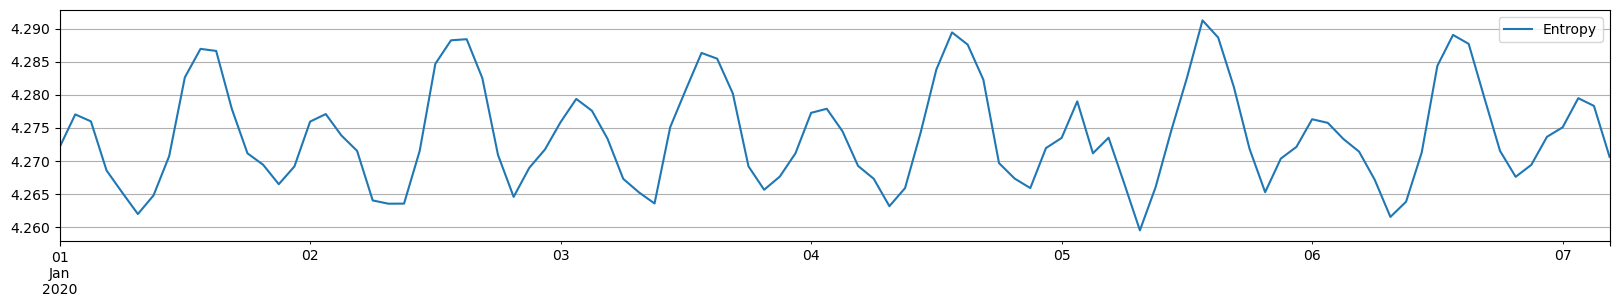

In [13]:
test["Entropy"].plot(figsize=(20,3))
plt.legend();plt.grid();plt.show()

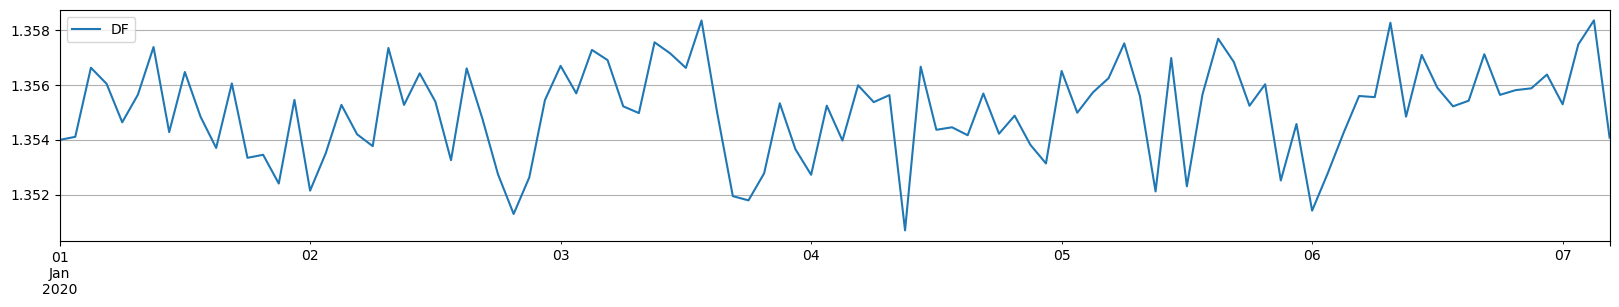

In [14]:
test["DF"].plot(figsize=(20,3))
plt.legend();plt.grid();plt.show()